In [12]:
import os
import zipfile

local_zip = '/tmp/chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

print(os.listdir('/tmp'))

['chest_xray.zip', '__MACOSX', '.ipynb_checkpoints', 'chest_xray']


In [27]:
base_dir = '/tmp/chest_xray'

train_dir = os.path.join(base_dir, 'train')
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

test_dir = os.path.join(base_dir, 'test')

validation_dir = os.path.join(base_dir, 'val')

train_normal_filenames = os.listdir(train_normal_dir)
print(train_normal_filenames[:10])
train_pneumonia_filenames = os.listdir(train_pneumonia_dir)
print(train_pneumonia_filenames[:10])

['NORMAL2-IM-0815-0001.jpeg', 'IM-0481-0001.jpeg', 'NORMAL2-IM-0535-0001-0002.jpeg', 'IM-0672-0001.jpeg', 'NORMAL2-IM-1243-0001.jpeg', 'NORMAL2-IM-0493-0001.jpeg', 'NORMAL2-IM-0651-0004.jpeg', 'NORMAL2-IM-1142-0001-0002.jpeg', 'NORMAL2-IM-1320-0001.jpeg', 'IM-0543-0001-0002.jpeg']
['person1429_bacteria_3691.jpeg', 'person899_virus_1553.jpeg', 'person516_virus_1033.jpeg', 'person1295_virus_2223.jpeg', 'person975_virus_1650.jpeg', 'person760_virus_1388.jpeg', 'person1666_bacteria_4416.jpeg', 'person1215_bacteria_3167.jpeg', 'person1639_bacteria_4347.jpeg', 'person71_bacteria_347.jpeg']


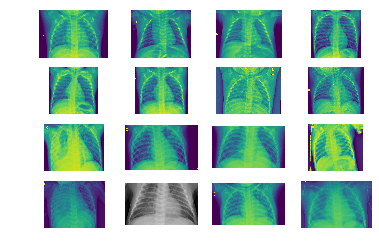

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 8
next_normal_pics = [os.path.join(train_normal_dir, filename) for filename in os.listdir(train_normal_dir)[pic_index - 8: pic_index]]
next_pneumonia_pics = [os.path.join(train_pneumonia_dir, filename) for filename in os.listdir(train_pneumonia_dir)[pic_index - 8: pic_index]]
for i, img_path in enumerate(next_normal_pics + next_pneumonia_pics):
  sp = plt.subplot(4, 4, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
  
plt.show()

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [0]:
def create_model(input_shape, num_classes):
  '''
    Create the image classifer based on pretrained InceptionV3
    
    Parameters
    ------------
    input_shape: Tuple
      Shape Tuple for Inception V3
    num_classes: Integer
      Number of classes to classify

    Returns
    --------
    The tensorflow model
  '''
  K.clear_session()
  
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  for layer in base_model.layers:
    layer.trainable = False
  
  predictions = Dense(num_classes, activation='sigmoid')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)
  
  return model

NUM_CLASSES = 2
model = create_model((150, 150, 3), NUM_CLASSES)
#model.summary()

In [0]:
optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [0]:
def count_file_dir(directory):
  '''
    Count files in a directory.
    
    Parameters
    ----------
    directory: String
      Given directory to count the files
      
    Returns
    -------
    Total number of files in the directory
  '''
  return sum([len(files) for files in os.walk(directory)])

In [33]:
rescale = 1./255
target_size = (150, 150)
batch_size = 500
class_mode = 'categorical'

train_datagen = ImageDataGenerator(rescale=rescale,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  validation_split=0.2)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=target_size,
                                                   class_mode=class_mode,
                                                   batch_size=batch_size,
                                                   shuffle=True)

Found 5216 images belonging to 2 classes.


In [34]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


In [39]:
val_datagen = ImageDataGenerator(rescale=rescale)
val_generator = val_datagen.flow_from_directory(validation_dir,
                                               target_size=target_size,
                                               class_mode=class_mode,
                                               batch_size=count_file_dir(validation_dir),
                                               shuffle=False)
history = model.fit_generator(train_generator,
                             steps_per_epoch=len(train_generator),
                             epochs=10,
                             verbose=1,
                             validation_data=val_generator,
                             validation_steps=len(val_generator),
                             class_weight=train_class_weights,
                             workers=20)

Found 16 images belonging to 2 classes.
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
11/11 [==============================] - 439s 40s/step - loss: 0.6271 - acc: 0.7044 - val_loss: 0.7531 - val_acc: 0.5000
Epoch 2/10
11/11 [==============================] - 344s 31s/step - loss: 0.5533 - acc: 0.7454 - val_loss: 0.7554 - val_acc: 0.5000
Epoch 3/10
11/11 [==============================] - 375s 34s/step - loss: 0.4818 - acc: 0.7636 - val_loss: 0.7422 - val_acc: 0.5000
Epoch 4/10
11/11 [==============================] - 369s 34s/step - loss: 0.4200 - acc: 0.8146 - val_loss: 0.8799 - val_acc: 0.5625
Epoch 5/10
11/11 [==============================] - 365s 33s/step - loss: 0.3624 - acc: 0.8487 - val_loss: 2.0858 - val_acc: 0.4375
Epoch 6/10
11/11 [==============================] - 364s 33s/step - loss: 0.3128 - acc: 0.8775 - val_loss: 1.7536 - val_acc: 0.6250
Epoch 7/10
11/11 [==============================] - 371s 34s/step - loss: 

In [41]:
test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=count_file_dir(test_dir),
                                                  shuffle=False)
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

Found 624 images belonging to 2 classes.
70/70 [==============================] - 38s 536ms/step - loss: 1.0841 - acc: 0.7196
